In [1]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
print(tf.__version__)

2.15.0


In [2]:
#난수 발생에 관련된 랜덤 시드를 고정
#딥러닝 모델의 재현성을 높이기 위해 가능한 모든 랜덤 시드를 미리 고정해 두는 것이 좋다.

SEED=12
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
print("시드 고정: ", SEED)

시드 고정:  12


데이터 전처리

In [5]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
X_data = housing.data
y_data= housing.target

print(X_data.shape, y_data.shape)

(20640, 8) (20640,)


In [9]:
#입력 데이터의 서로 다른 피처 값의 범위를 비슷한 크기로 맞춰 주면 딥러닝 모델의 성능을 확보하는데 유리
#피처 스케일링
from sklearn.preprocessing import MinMaxScaler  #모든 피처 값을 0~1 범위로 정규화 처리
scaler = MinMaxScaler()
X_data_scaled = scaler.fit_transform(X_data)
X_data_scaled[0]

array([0.53966842, 0.78431373, 0.0435123 , 0.02046866, 0.00894083,
       0.00149943, 0.5674814 , 0.21115538])

In [13]:
#모델 학습에 사용하기 위해 훈련 데이터(80%) 검증 데이터(20%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle = True, random_state = SEED)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(16512, 8) (16512,)
(4128, 8) (4128,)


MLP 모델 아키텍처 정의

완전 연결(Dense) 레이어만 사용하여 5개 레이어를 갖는 다층 신경망 MLP 만들자

레이어를 추가할 때는 add함수를 사용

은닉 레이어4개는 각각 128개 64개 32개 16개의 유닛을 갖는다

입력 데이터의 피처가 8개이므로 첫번째 Dense 레이어의 input_dim에 8을 지정

목표 레이블이 한 개인 회귀 문제니깐 마지막 출력 레이어는 1개의 유닛을 갖고 선형 함수를 활성화 함수로 설정.

은닉 레이어의 활성화 함수로는 ReLU 함수를 많이 사용한다.

ReLU함수는 입력이 0보다 크면 그대로 출력하고 0이하는 0을 출력한다

모두 12033개의 모수(파라미터)를 갖는 MLP모델이 생성되는데,
모델의 레이어 개수와 각 레이어의 유닛 수를 변경하여 최적을 모델 아키텍처를 찾는 것이 필요

어떤 레이어를 사용할 것인지, 레이어 몇개를 사용할 것인지, 각 레이어의 유닛을 몇 개 사용할 것인지 등이 모두 모델 성능에 영향을 준다.

따라서 다양한 모델을 비교하여 성능을 업그레이드한다.

In [15]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
def build_model(num_input=1):
  model = Sequential()
  model.add(Dense(128, activation='relu',input_dim=num_input))  #은닉층
  model.add(Dense(64, activation='relu',input_dim=num_input)) #은닉층
  model.add(Dense(32, activation='relu',input_dim=num_input)) #은닉층
  model.add(Dense(16, activation='relu',input_dim=num_input)) #은닉층
  model.add(Dense(1, activation='linear',input_dim=num_input))  #마지막 출력 레이어

  model.compile(optimizer='adam',loss='mse', metrics=['mae'])

  return model

model = build_model(num_input=8)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               1152      
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 12033 (47.00 KB)
Trainable params: 12033 (47.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


미니 배치 학습

모델을 훈련시킬 때 샘플 데이터를 한 개씩 입력해서 가중치를 갱신하려면 학습 시간이 오래걸리는 문제가 있다

미니 배치 학습은 전체 데이터를 여러 개의 작은 배치 단위로 나누고 배치에 들어 있는 샘플 데이터를 묶어서 모델에 입력한다

배치 단위로 경사하강법을 적용하고 손실 함수를 최소화하는 방향으로 가중치를 업데이트하자

훈련데이터(16512개 이므로) 1271개씩 묶으면 13개의 미니 배치가 만들어진다.

전체 데이터를 한꺼번에 입력하지 않고 1271개씩 입력하므로 한방에 하는 것보단 메모리 부담이 작아지는 장점

실행 결과를 보면 매 에포크가 진행될 때마다 손실 함수의 출력값이 감소하고 있으므로 학습이 잘 진행되는 것으로 볼 수 있다.

In [16]:
#모델 훈련
model.fit(X_train,y_train, epochs=100, batch_size = 1271, verbose=0)

In [17]:
#evaluate함수를 통해 모델의 일반화 성능을 평가하자.

#평가
model.evaluate(X_test,y_test)

129/129 [==============================] - 1s 8ms/step - loss: 0.5618 - mae: 0.5488


[0.561789870262146, 0.548808217048645]

교차 검증

학습 데이터 일부(여기서는 25%)를 검증 데이터를 사용하여 교차 검증을 해보자.

fit 메소드의 validation_split 옵션에 테스트 데이터셋 비율을 입력하면 됨

마지막 에포크 학습이 끝났을 때

만약 훈련 손실(loss)이 검증 손실(val_loss)보다 작은 값이면, 과대적합상태로 판단


In [18]:
model = build_model(num_input=8)
history = model.fit(X_train,y_train, batch_size = 1271, epochs=200, validation_split=0.25, verbose=2)

Epoch 1/200
10/10 - 2s - loss: 2136.1519 - mae: 28.2805 - val_loss: 207.9321 - val_mae: 10.0677 - 2s/epoch - 223ms/step
Epoch 2/200
10/10 - 0s - loss: 116.5842 - mae: 6.7907 - val_loss: 27.6834 - val_mae: 4.7952 - 158ms/epoch - 16ms/step
Epoch 3/200
10/10 - 0s - loss: 21.6169 - mae: 3.6362 - val_loss: 12.0074 - val_mae: 2.2322 - 160ms/epoch - 16ms/step
Epoch 4/200
10/10 - 0s - loss: 7.4478 - mae: 1.8479 - val_loss: 5.3932 - val_mae: 1.9712 - 191ms/epoch - 19ms/step
Epoch 5/200
10/10 - 0s - loss: 2.9756 - mae: 1.2896 - val_loss: 2.3417 - val_mae: 1.0661 - 149ms/epoch - 15ms/step
Epoch 6/200
10/10 - 0s - loss: 1.8443 - mae: 1.0227 - val_loss: 1.8442 - val_mae: 0.9198 - 146ms/epoch - 15ms/step
Epoch 7/200
10/10 - 0s - loss: 1.4757 - mae: 0.9214 - val_loss: 1.6705 - val_mae: 0.8874 - 91ms/epoch - 9ms/step
Epoch 8/200
10/10 - 0s - loss: 1.3909 - mae: 0.9070 - val_loss: 1.5792 - val_mae: 0.9075 - 103ms/epoch - 10ms/step
Epoch 9/200
10/10 - 0s - loss: 1.3588 - mae: 0.9072 - val_loss: 1.5640 -

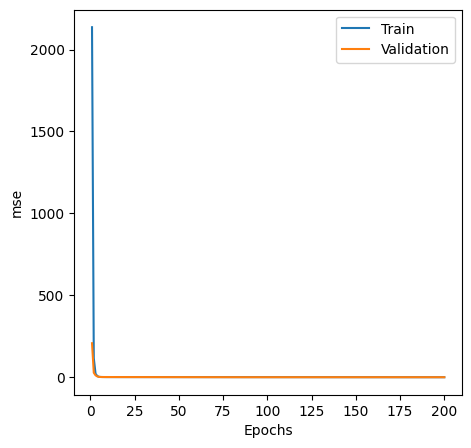

In [20]:
#훈련 손실과 검증 손실을 그래프로 나타내보자
#가로축에는 에포크를 놓고, 세로축에는 손실 함수 값을 표시
#모델은 10에포크까지 매우 빠른 속도로 학습이 되고, 이후 점차 완만하게 학습 속도가 낮아지면서 그래프가 평평해지는 추이를 보인다

import matplotlib.pyplot as plt
def plot_loss_curve(total_epoch=10, start=1):
  plt.figure(figsize=(5,5))
  plt.plot(range(start, total_epoch+1),
           history.history['loss'][start-1:total_epoch],
           label='Train')
  plt.plot(range(start, total_epoch+1),
           history.history['val_loss'][start-1:total_epoch],
           label='Validation')
  plt.xlabel('Epochs')
  plt.ylabel('mse')
  plt.legend()
  plt.show()
plot_loss_curve(total_epoch=200, start=1)

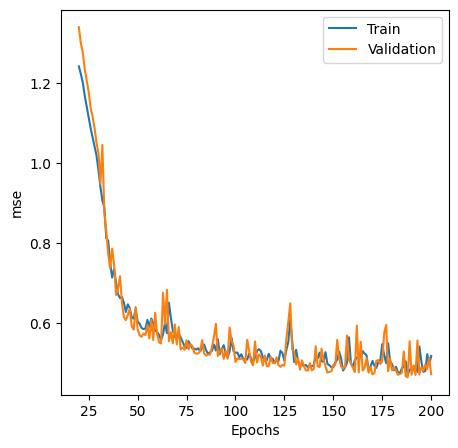

In [21]:
plot_loss_curve(total_epoch=200,start=20)